### Visualization of NYC traffic based on output from Neural Network trained on the taxi trips

This is work in progress for creating visual graphics for NYC traffic heatmaps.

by DataQubit, June 2019

In [ ]:
import numpy as np
import pandas as pd
import os
import bq_helper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from mpl_toolkits.basemap import Basemap
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.externals import joblib
pd.options.mode.chained_assignment = None  # default='warn'
import os
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from zipfile import ZipFile

In [ ]:
def create_download_link(filename = "/tmp/weights.hdf5", title = "Download file"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [ ]:
%%bash
conda install basemap-data-hires

In [ ]:
ls -lth ../input/nyc-taxi-trips-nn-weights/

In [ ]:
ls -lth ../input/keras-weights-and-stscaler-for-nyc-trip-duration/

In [ ]:
df_yell_jan = pd.read_csv('../input/nyc-taxi-trips-nn-weights/nyc_yellow_trips_geo_time_Only_2016_Jan.csv')

In [ ]:
### consider only range of lat lon:
df_yell_jan = df_yell_jan[(df_yell_jan.dropoff_longitude.between(-74.03, -73.94) & df_yell_jan.dropoff_latitude.between(40.7, 40.8)
                          & df_yell_jan.pickup_longitude.between(-74.03, -73.94) & df_yell_jan.pickup_latitude.between(40.7, 40.8))]

In [ ]:
df_yell_jan['pickup_datetime'] = pd.to_datetime(df_yell_jan.pickup_datetime)
df_yell_jan['dropoff_datetime'] = pd.to_datetime(df_yell_jan.dropoff_datetime)
# minutes since midnight
df_yell_jan['pickup_day_minute'] = df_yell_jan.pickup_datetime.dt.hour * 60 + df_yell_jan.pickup_datetime.dt.minute
df_yell_jan['pickup_day_15min'] = np.ceil(df_yell_jan.pickup_day_minute / 15)
df_yell_jan['duration'] = (df_yell_jan.dropoff_datetime - df_yell_jan.pickup_datetime).dt.seconds
# Filter out trips longer than 1 hour:
df_yell_jan = df_yell_jan.query('duration <= 3600.')

In [ ]:
feature_cols = ['pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude',
    'pickup_day_15min']

In [ ]:
# standardization
#stSc = StandardScaler()
#stSc.fit(df_yell_jan[feature_cols])

In [ ]:
stSc = joblib.load('../input/new-york/standardScaler_NYC_taxi_trips_Jun8.pkl')

### Creating a model and loading the weights

In [ ]:
model = Sequential()
model.add(Dense(units=64, activation='elu', input_dim=5, kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dense(units=64, activation='elu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dense(units=64, activation='elu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dense(units=64, activation='elu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dense(units=1))

In [ ]:
model.summary()

In [ ]:
model.load_weights('../input/new-york/NYC_taxi_trips_Jun8_Best_weights.hdf5')

### Evaluation on a test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(stSc.transform(df_yell_jan[feature_cols]), 
    df_yell_jan.duration, test_size=0.33, random_state=42)

In [ ]:
train_ix, test_ix, _, _ = train_test_split(np.arange(len(df_yell_jan[feature_cols])), 
    np.arange(len(df_yell_jan[feature_cols])), test_size=0.33, random_state=42)

In [ ]:
y_test_predict = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_test_predict)

In [ ]:
df_test = df_yell_jan[feature_cols + ['duration']].iloc[test_ix]

In [ ]:
# sanity check
mean_squared_error(y_test, model.predict(stSc.transform(df_test.values)))

In [ ]:
df_test['pred_duration'] = y_test_predict

In [ ]:
df_test['error_duration'] = df_test.duration - df_test.pred_duration

In [ ]:
df_test.head()

In [ ]:
len(df_test)

In [ ]:
df_test.error_duration.div(60.).plot(kind='hist', bins=50, figsize=(20, 4))

### Visualization

In [ ]:
llcrnrlat, llcrnrlon = 40.70, -74.02
urcrnrlat, urcrnrlon = 40.80, -73.94
lon_c, lat_c = (-73.98102945267891, 40.752651226891864)
m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
             resolution='f', projection='tmerc', lat_0 = lat_c, lon_0 = lon_c)

#### Visualization on a test set:

In [ ]:
np.random.seed(42)
subset_ix = np.random.choice(np.arange(len(df_test)), size=20000, replace=False)

In [ ]:
drop_x_test, drop_y_test = m(df_test.dropoff_longitude.iloc[subset_ix].values, df_test.dropoff_latitude.iloc[subset_ix].values)

In [ ]:
def plot_error_test_set():
    plt.figure(figsize=(20,10))
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(color='yellow')
    m.scatter(drop_x_test, drop_y_test, c=df_test.error_duration.iloc[subset_ix], cmap=plt.get_cmap('hot'), alpha=0.1)
    plt.show()

In [ ]:
plot_error_test_set()

### Plot Duration HeatMap

In [ ]:
df_subs = df_yell_jan.iloc[:20000]

In [ ]:
x, y = m(df_subs.dropoff_longitude.values, df_subs.dropoff_latitude.values)

In [ ]:
df_subs.loc[df_subs.index, 'x'] = x
df_subs.loc[df_subs.index, 'y'] = y

In [ ]:
df_subs.head()

In [ ]:
mkdir -p traffic_heatmaps/sample_2/

In [ ]:
def plot_duration_map(pick_long, pick_lat, pick_day_time, save_to_dir='', vmax=None, vmin=None):
    X_map = np.vstack([pick_long * np.ones(len(df_subs)), 
                      pick_lat * np.ones(len(df_subs)),
                      df_subs.dropoff_longitude.values,
                      df_subs.dropoff_latitude.values,
                      pick_day_time * np.ones(len(df_subs))]).T
    pred_duration = (model.predict(stSc.transform(X_map)) / 60.).flatten()
    pick_x, pick_y = m(pick_long, pick_lat)
    plt.figure(figsize=(20,10))
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(color='yellow')
    m.scatter(df_subs.x, df_subs.y, c=pred_duration, cmap=plt.get_cmap('hsv'), 
              alpha=0.5, vmin=vmin, vmax=vmax)
    m.scatter(pick_x, pick_y, marker='X', s=200, c='yellow')
    plt.title("Time: " + pd.to_datetime(15 * pick_day_time, unit='m').strftime('%H:%M'))
    if save_to_dir:
        plt.savefig(save_to_dir + 'traffic_heatmap_hour_%s.png' 
                    %pd.to_datetime(15 * pick_day_time, unit='m').strftime('%H'), bbox_inches='tight')
    plt.show()

In [ ]:
for j in range(8, 12):
    plot_duration_map(df_subs.dropoff_longitude.iloc[j], df_subs.dropoff_latitude.iloc[j], 1000 / 15)

In [ ]:
df_test.pickup_day_15min.max()

In [ ]:
df_subs

In [ ]:
for day_time_15min in range(0, 97, 4):

In [ ]:
### Through the time of day
for day_time_15min in range(0, 97, 4):
    plot_duration_map(df_subs.dropoff_longitude.iloc[9], df_subs.dropoff_latitude.iloc[9], day_time_15min, 
                      save_to_dir='')

In [ ]:
### Through the time of day
for day_time_15min in range(0, 97, 4):
    plot_duration_map(df_subs.dropoff_longitude.iloc[8], df_subs.dropoff_latitude.iloc[8], day_time_15min, 
                      save_to_dir='traffic_heatmaps/sample_2/')

In [ ]:
ls -lth traffic_heatmaps/sample_1/

In [ ]:
# create a ZipFile object
with ZipFile('traffic_heatmaps_sample2.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('traffic_heatmaps/sample_2/'):
        for filename in filenames:
            #create complete filepath of file in directory
            if 'png' in filename:
                filePath = os.path.join(folderName, filename)
                # Add file to zip
                zipObj.write(filePath)

In [ ]:
create_download_link('traffic_heatmaps_sample2.zip')

In [ ]:
# create a ZipFile object
with ZipFile('reach_time_heatmaps.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('reach_heatmaps/'):
        for filename in filenames:
            #create complete filepath of file in directory
            if 'png' in filename:
                filePath = os.path.join(folderName, filename)
                # Add file to zip
                zipObj.write(filePath)

In [ ]:
create_download_link('reach_time_heatmaps.zip')

In [ ]:
ls -lth

### Reach Heatmap

In [ ]:
df_subs.head()

In [ ]:
df_reach = df_subs[['dropoff_longitude', 'dropoff_latitude', 'x', 'y']]

In [ ]:
df_reach.reset_index(inplace=True, drop=True)

In [ ]:
df_reach['reach_median'] = np.nan
df_reach['reach_mean'] = np.nan

In [ ]:
df_reach.head()

In [ ]:
def get_reach_time(ix_j, pick_day_time):
    sample_size = 1000
    drop_long, drop_lat = df_reach[['dropoff_longitude', 'dropoff_latitude']].iloc[ix_j]
    X_map = np.vstack([df_reach.dropoff_longitude.loc[df_reach.index!=ix_j].values[:sample_size], 
                       df_reach.dropoff_latitude.loc[df_reach.index!=ix_j].values[:sample_size],
                       drop_long * np.ones(sample_size),
                       drop_lat * np.ones(sample_size),
                       pick_day_time * np.ones(sample_size)]).T
    pred_duration = pd.Series((model.predict(stSc.transform(X_map)) / 60.).flatten())
    return pred_duration.median(), pred_duration.mean()

In [ ]:
all_df_reach = []
for day_time_15min in range(0, 97, 4):
    df_reach.loc[df_reach.index, ['reach_median', 'reach_mean']] = [get_reach_time(j, day_time_15min) 
                                                                    for j in df_reach.index]
    all_df_reach.append(df_reach.copy())

In [ ]:
df_all_reach = pd.concat(all_df_reach, ignore_index=False)

In [ ]:
df_all_reach.head()

In [ ]:
df_all_reach.to_csv('df_all_reach_25hours_reachMaps.csv', index=None)

In [ ]:
create_download_link('df_all_reach_25hours_reachMaps.csv')

In [ ]:
len(df_all_reach)

In [90]:
def plot_reach_heatmap(df_reach, hour, vmin=None, vmax=None, save_to_dir=""):
    plt.figure(figsize=(20,10))
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(color='yellow')
    sc_plot = m.scatter(df_reach_i.x, df_reach_i.y, c=df_reach_i.reach_median, cmap=plt.get_cmap('nipy_spectral'), 
        alpha=0.5, vmin=vmin, vmax=vmax)
    cbar = m.colorbar(sc_plot,location='right',pad="5%")
    cbar.set_label('min')
    plt.title("Time: " + pd.to_datetime(hour * 60, unit='m').strftime('%H:%M'))
    if save_to_dir:
        plt.savefig(save_to_dir + 'reach_time_heatmap_%s.png' 
                    %pd.to_datetime(hour * 60, unit='m').strftime('%H'), bbox_inches='tight')

In [ ]:
mkdir reach_heatmaps

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


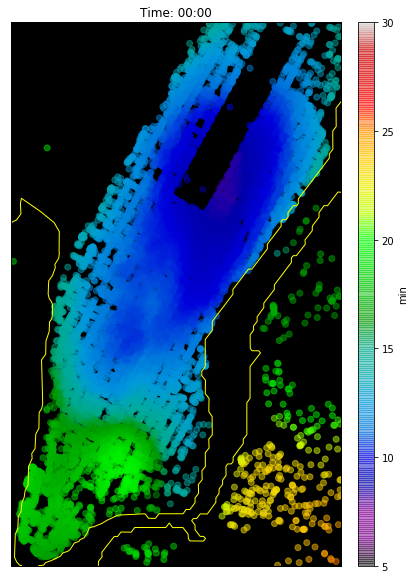

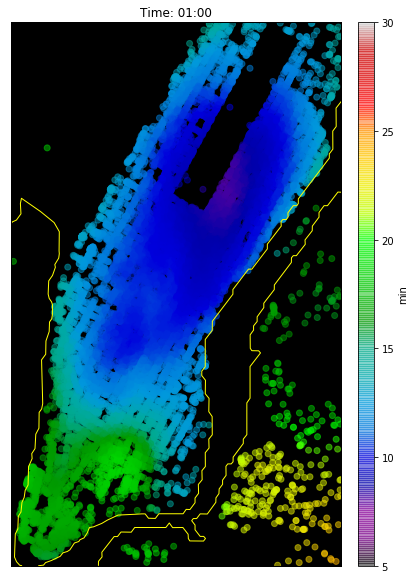

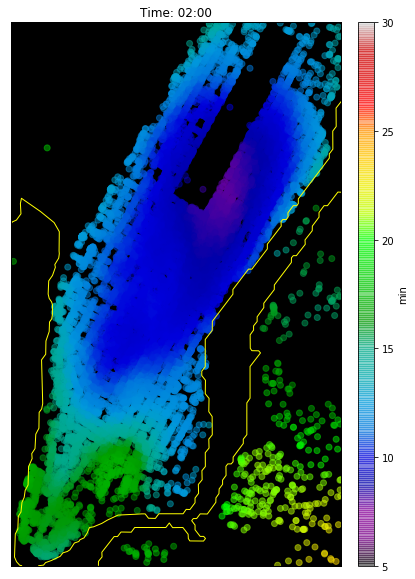

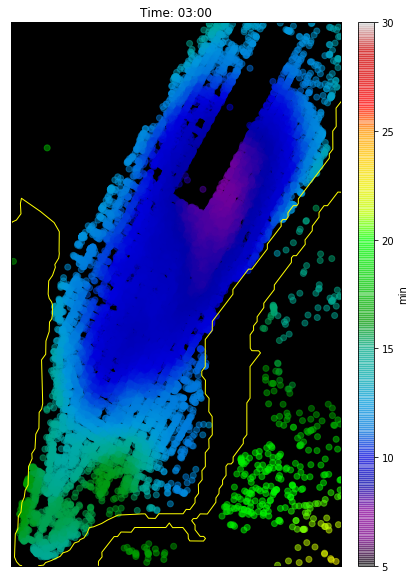

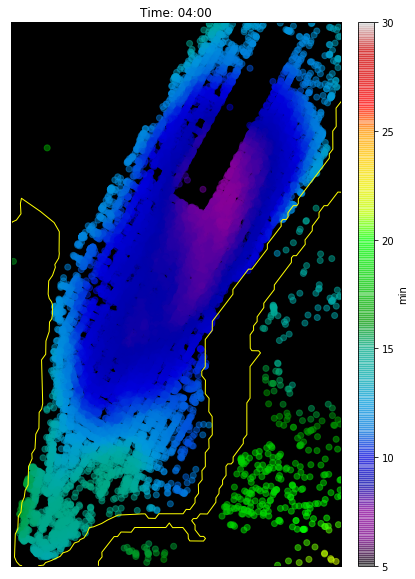

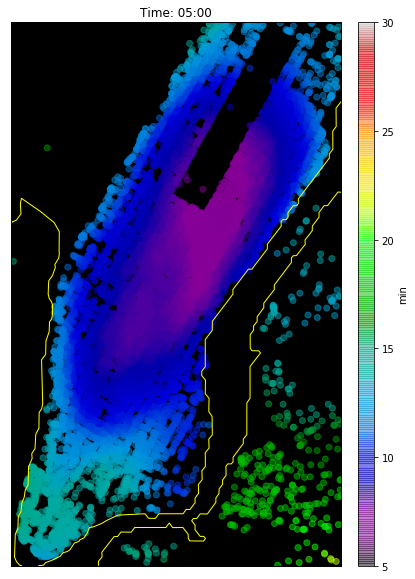

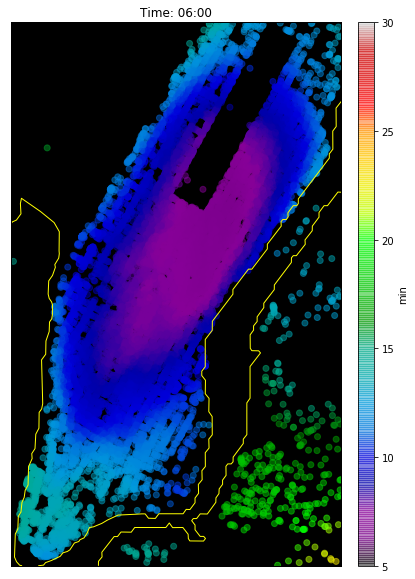

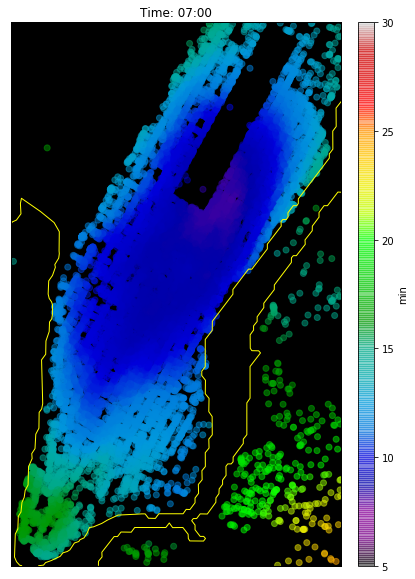

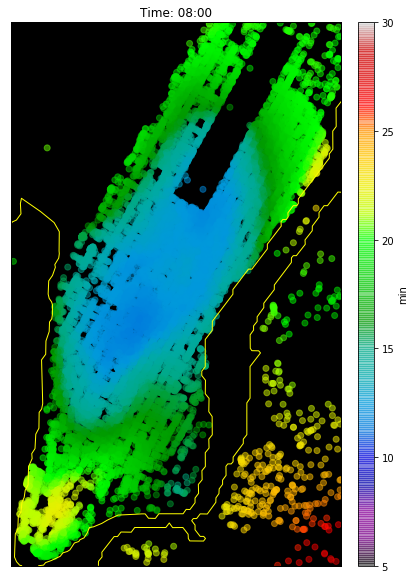

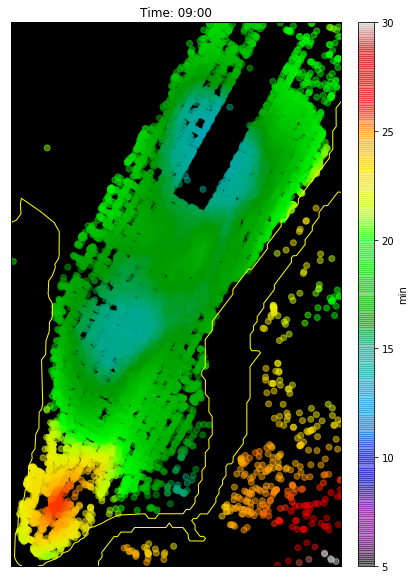

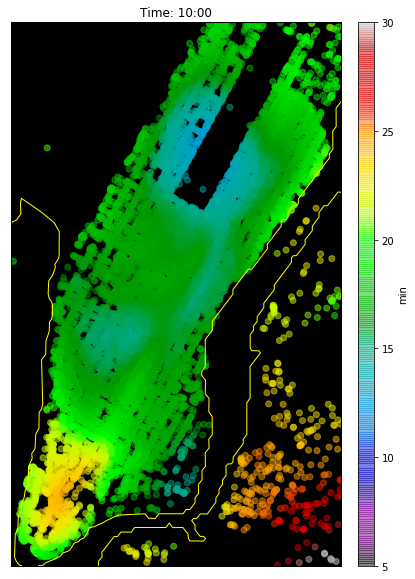

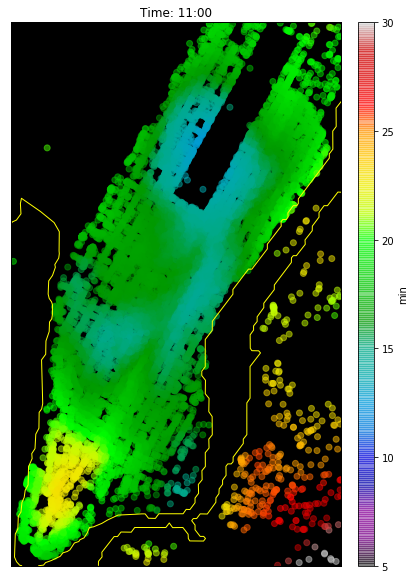

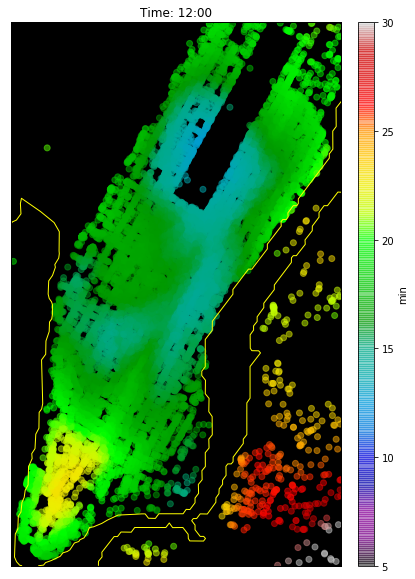

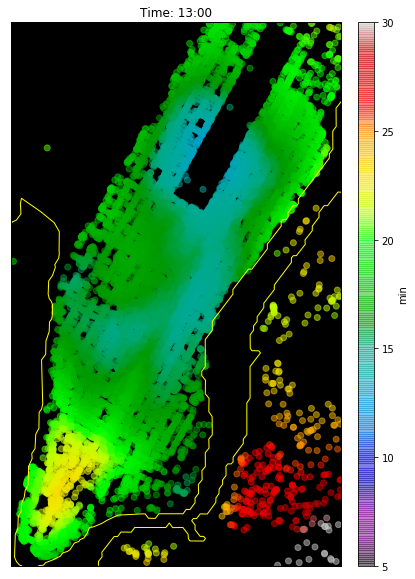

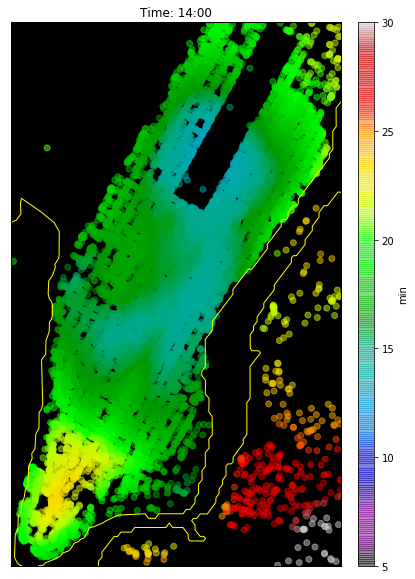

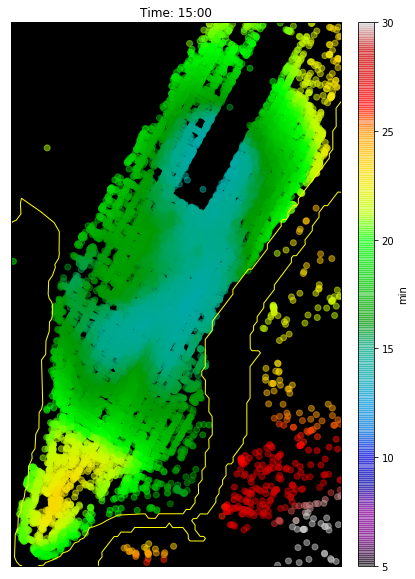

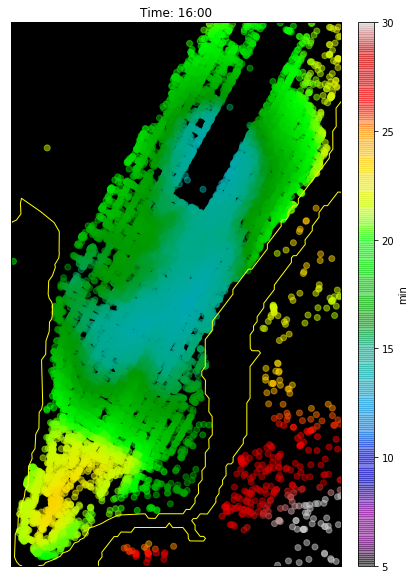

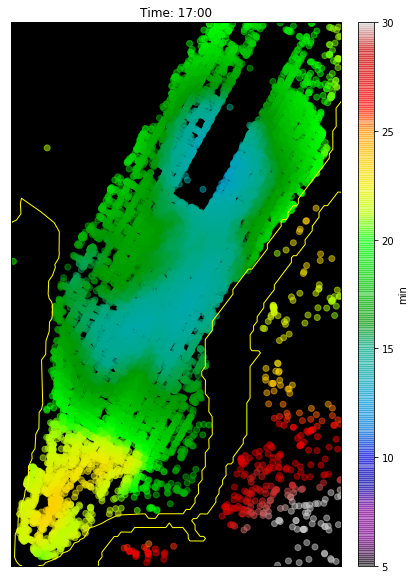

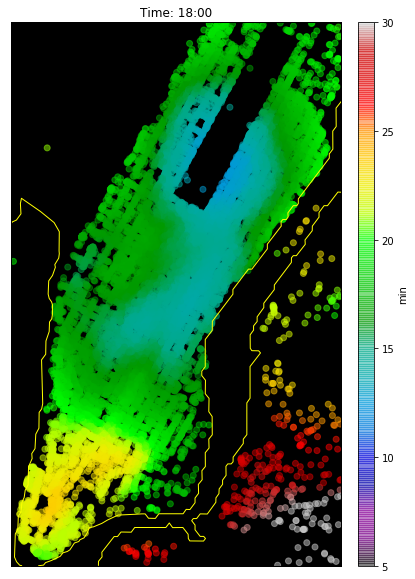

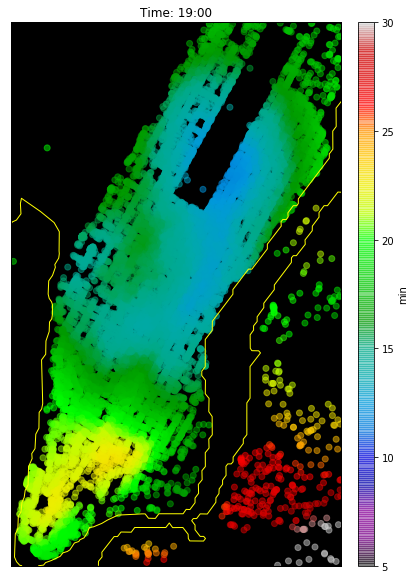

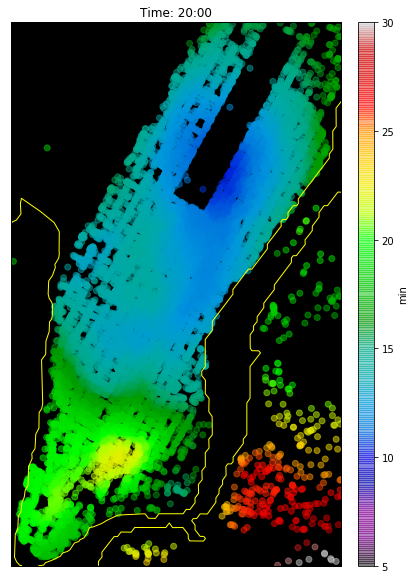

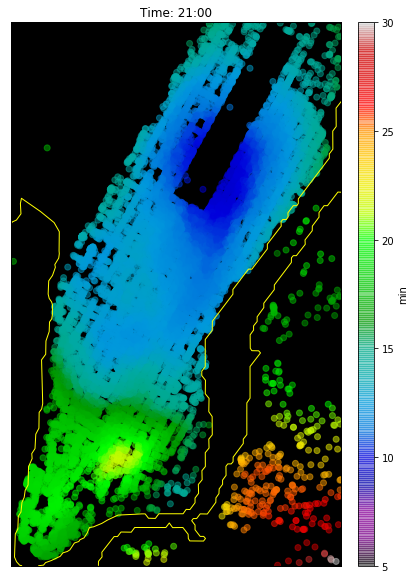

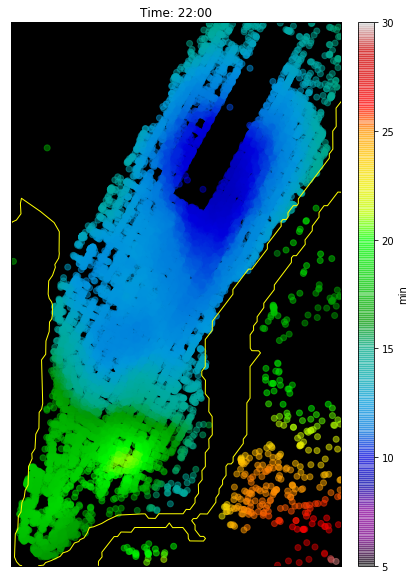

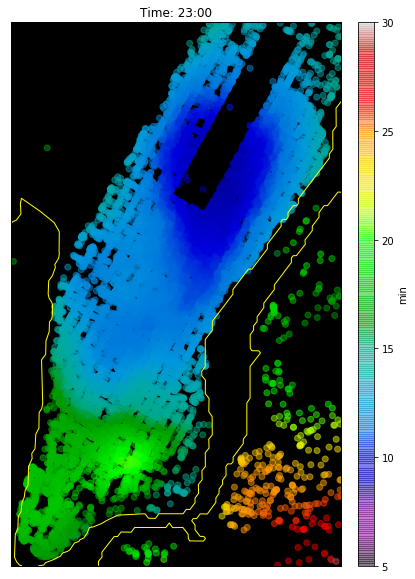

In [91]:
num_points = 20000
for hour in range(24):
    df_reach_i = df_all_reach.iloc[hour * num_points: (hour + 1) * num_points]
    plot_reach_heatmap(df_reach_i, hour, vmin=5, vmax=30, save_to_dir="reach_heatmaps/")

In [ ]:
ls -lth reach_heatmaps/

In [ ]:
plt.figure(figsize=(20,10))
m.drawmapboundary(fill_color='black')
m.drawcoastlines(color='yellow')
sc_plot = m.scatter(df_reach.x, df_reach.y, c=df_reach.reach_mean, cmap=plt.get_cmap('jet'), 
    alpha=0.5, vmax=20)
cbar = m.colorbar(sc_plot,location='right',pad="5%")
cbar.set_label('min')

In [ ]:
pred_duration.plot(kind='hist', figsize=(15, 5), bins=50)

In [ ]:
pred_duration.median()

### HeatMaps variations

In [ ]:
df_one_day = df_yell_jan[df_yell_jan.pickup_datetime.between(pd.to_datetime('2016-01-14'), pd.to_datetime('2016-01-15'))]

In [ ]:
df_one_day.tail()

In [ ]:
len(df_one_day)

In [ ]:
mkdir dayli_heatmaps

In [ ]:
ls -lth

In [ ]:
ls -lth dayli_heatmaps/

In [ ]:
%%bash
convert dayli_heatmaps/*.png dayli_heatmaps/whole_day_dynamics.gif

In [ ]:
# duration as a heatmap
for hr in range(24):
    df_i = df_one_day[df_one_day.pickup_datetime.dt.hour==hr]
    drop_x, drop_y = m(df_i.dropoff_longitude.values, df_i.dropoff_latitude.values)
    pick_x, pick_y = m(df_i.pickup_longitude.values, df_i.pickup_latitude.values)
    plt.figure(figsize=(20,10))
    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(color='yellow')
    m.scatter(drop_x, drop_y, c='lightgreen', alpha=0.1)
    m.scatter(pick_x, pick_y, c='red', alpha=0.1)
    plt.title("Hour: %d; Trips: %d" %(hr, len(df_i)))
    plt.savefig('dayli_heatmaps/pickups_dropoffs_hour_%d.png' %hr, bbox_inches='tight')
    plt.show()

In [ ]:
for fl in os.listdir('dayli_heatmaps/'):
    create_download_link('dayli_heatmaps/%s' %fl)

In [ ]:
create_download_link(filename='dayli_heatmaps/pickups_dropoffs_hour_0.png')

In [ ]:
create_download_link(filename='dayli_heatmaps/pickups_dropoffs_hour_13.png')

In [ ]:
create_download_link(filename='dayli_heatmaps/pickups_dropoffs_hour_2.png')